In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!wget https://datasets.simula.no/downloads/kvasir/kvasir-dataset-v2.zip
!unzip kvasir-dataset-v2.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: ./kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: ./kvasir-dataset-v2/normal

In [130]:
# Load the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from poutyne.framework import Model, Callback
from google.cloud import storage
import poutyne

In [85]:
# Define the directory path
model_dir = '/content/models'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [86]:
# Create a Subset Class with Different Transformations
class CustomSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        sample, target = self.dataset[self.indices[idx]]
        if self.transform:
            sample = self.transform(sample)
        return sample, target

    def __len__(self):
        return len(self.indices)

In [87]:
# Define data transformations for train and validation datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [88]:
# Load the Kvasir GI dataset
dataset_path = '/content/kvasir-dataset-v2/'
dataset = ImageFolder(dataset_path)

# Split the dataset into train and validation sets
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
valid_size = total_samples - train_size
train_indices = np.random.choice(total_samples, train_size, replace=False)
valid_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Create custom datasets with different transformations
train_dataset = CustomSubset(dataset, train_indices, transform=train_transform)
valid_dataset = CustomSubset(dataset, valid_indices, transform=valid_transform)

# Define batch size and create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

Number of classes: 8
Class labels: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Number of samples: 8000


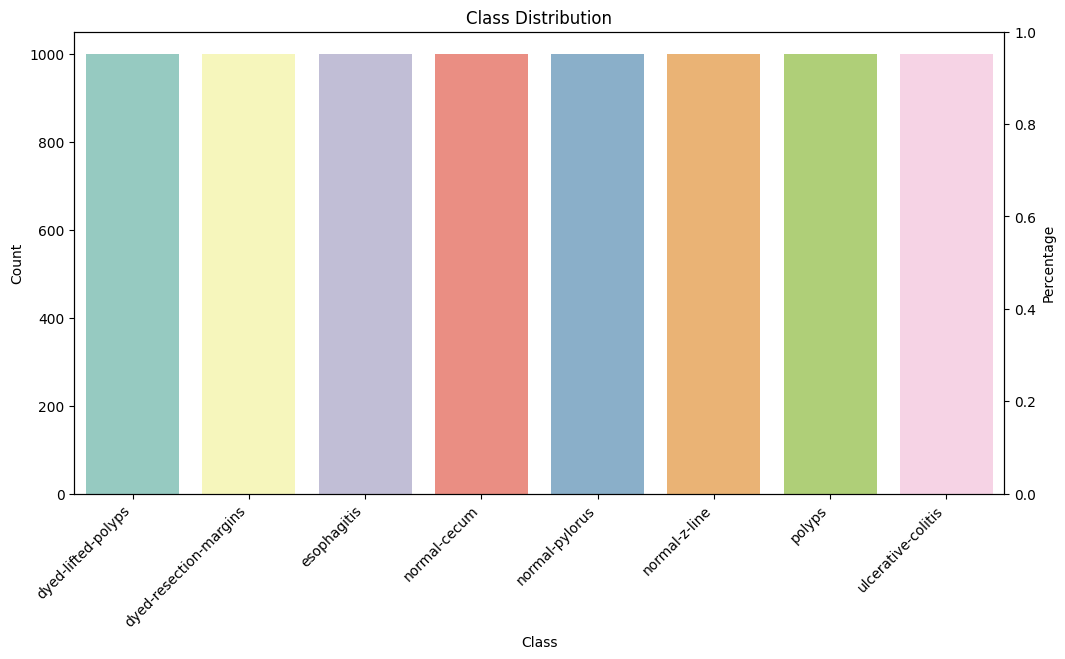

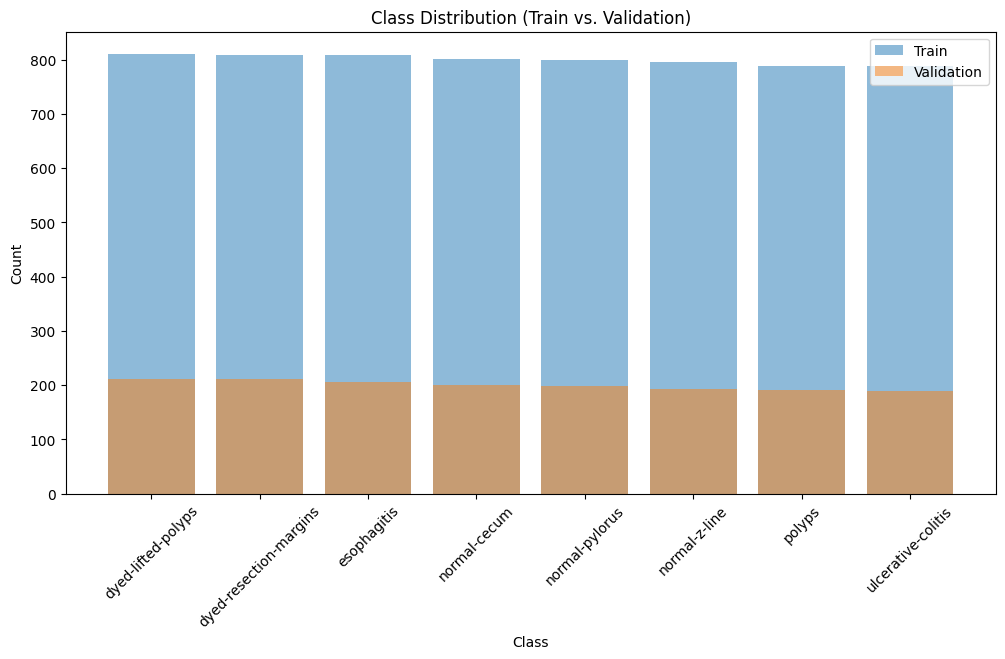

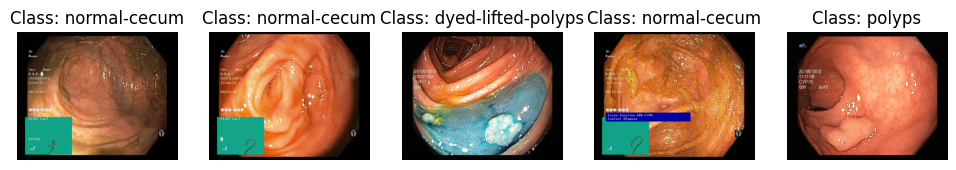

In [144]:
# EDA

# 1. Basic Dataset Information:
print("Number of classes:", len(dataset.classes))
print("Class labels:", dataset.classes)
print("Number of samples:", len(dataset))

# Get class names (labels)
class_names = dataset.classes

# Calculate class counts
class_counts = pd.Series(dataset.targets).value_counts()

# Calculate class percentages
class_percentages = (class_counts / len(dataset)) * 100

# 2. Class Distribution:
# Plot the class distribution with percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_counts, palette="Set3")
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.gca().set_xticklabels(class_names, rotation=45, ha='right')
plt.twinx()  # Create a secondary y-axis for percentages
plt.ylabel('Percentage')
plt.show()

# Access the targets from the original dataset
train_targets = [train_dataset[i][1] for i in range(len(train_dataset))]
valid_targets = [valid_dataset[i][1] for i in range(len(valid_dataset))]

# Create a Pandas Series from the targets
train_class_counts = pd.Series(train_targets).value_counts().reset_index()
valid_class_counts = pd.Series(valid_targets).value_counts().reset_index()

train_class_counts.columns = ['Class', 'Count']
valid_class_counts.columns = ['Class', 'Count']

# Plot the class distribution for the train and validation sets
plt.figure(figsize=(12, 6))
plt.bar(class_names, train_class_counts['Count'], alpha=0.5, label='Train')
plt.bar(class_names, valid_class_counts['Count'], alpha=0.5, label='Validation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Train vs. Validation)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 3. Data Visualization (e.g., sample images):
# Define a function to display sample images
def show_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        sample_idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[sample_idx]
        plt.imshow(image)
        plt.title(f'Class: {dataset.classes[label]}')
        plt.axis('off')
    plt.show()

# Display a few sample images
show_sample_images(dataset)

# 4. Data Preprocessing:
# You can define image transformations if needed (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply the transformation to a sample image
sample_image, sample_label = dataset[0]
sample_image = transform(sample_image)

# Define a data augmentation pipeline
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])


In [89]:
import torchvision.models as models
import torch.optim as optim

class MobileNetOne(nn.Module):
    def __init__(self, num_classes=8):
        super(MobileNetOne, self).__init__()
        # Load a pre-trained MobileNetV2 model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        # Modify the classifier for your task
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [90]:
# Create the MobileNetOne model
model = MobileNetOne(num_classes=8)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetOne(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [96]:
from poutyne.framework.callbacks import Callback

# Define a custom callback for early stopping

class EarlyStoppingCallback(Callback):
    def __init__(self, monitor='val_loss', patience=5, mode='min'):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.wait = 0
        self.stopped_epoch = 0
        self.best_score = None

    def on_epoch_end(self, epoch_number, logs):
        current_score = logs.get(self.monitor)
        if self.best_score is None or \
           (self.mode == 'min' and current_score < self.best_score) or \
           (self.mode == 'max' and current_score > self.best_score):
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch_number
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping after epoch {self.stopped_epoch}.")

# Create an instance of the modified EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(monitor='val_loss', patience=5, mode='min')

In [104]:
# Define custom callback to upload the model on google cloud:

class UploadModelCallback(poutyne.Callback):
    def __init__(self, bucket_name, remote_dir, num_epochs=1):
        super().__init__()
        self.num_epochs = num_epochs
        self.bucket_name = bucket_name
        self.remote_dir = remote_dir
        self.local_dir = "/content/models"

        self.storage_client = storage.Client()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) >= 1:  # Upload the model checkpoint after each epoch
            # Save the model checkpoint locally
            checkpoint_path = os.path.join(self.local_dir, f"MobileOne_model-{epoch + 1:02d}.ckpt")
            self.model.save_weights(checkpoint_path)

            # Upload the model checkpoint to Google Cloud Storage
            remote_filepath = os.path.join(self.remote_dir, os.path.basename(checkpoint_path))
            bucket = self.storage_client.bucket(self.bucket_name)
            blob = bucket.blob(remote_filepath)
            blob.upload_from_filename(checkpoint_path)

            print(f"Model checkpoint saved in {checkpoint_path} and uploaded to {remote_filepath}")

In [103]:
# Train the model with upload callback
num_epochs = 10
bucket_name = "tibot-ml-labeling"
remote_dir = "models/kvasir_GI_task/sarim/MobileOne_model_/model"

# Create a Poutyne Model
poutyne_model = Model(model, optimizer, criterion, batch_metrics=['accuracy']).to(device)

# Define callbacks for monitoring and saving the best model
callbacks_list = [
    early_stopping,
    UploadModelCallback(bucket_name, remote_dir, num_epochs=num_epochs)
]

In [105]:
# Train the model
num_epochs = 10
history = poutyne_model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks_list)

Epoch:  1/10 Train steps: 100 Val steps: 25 2m7.87s loss: 0.212872 acc: 91.828125 val_loss: 0.214335 val_acc: 92.000000
Model checkpoint saved in /content/models/MobileOne_model-02.ckpt and uploaded to models/kvasir_GI_task/sarim/MobileOne_model_/model/MobileOne_model-02.ckpt
Epoch:  2/10 Train steps: 100 Val steps: 25 2m7.27s loss: 0.219481 acc: 91.156250 val_loss: 0.228259 val_acc: 91.812500
Model checkpoint saved in /content/models/MobileOne_model-03.ckpt and uploaded to models/kvasir_GI_task/sarim/MobileOne_model_/model/MobileOne_model-03.ckpt
Epoch:  3/10 Train steps: 100 Val steps: 25 2m7.14s loss: 0.199820 acc: 92.328125 val_loss: 0.204831 val_acc: 92.937500
Model checkpoint saved in /content/models/MobileOne_model-04.ckpt and uploaded to models/kvasir_GI_task/sarim/MobileOne_model_/model/MobileOne_model-04.ckpt
Epoch:  4/10 Train steps: 100 Val steps: 25 2m7.12s loss: 0.192009 acc: 92.390625 val_loss: 0.238297 val_acc: 91.625000
Model checkpoint saved in /content/models/MobileO

In [120]:
import numpy as np

# Collect validation data during training (before starting training)
val_targets = []  # To store validation targets
val_predictions = []  # To store model predictions

for x_val, y_val in valid_loader:
    # Get model predictions for validation data
    y_pred_val = poutyne_model.predict(x_val)

    # Append validation targets and predictions
    val_targets.extend(y_val.numpy().tolist())
    val_predictions.extend(y_pred_val.tolist())  # No need for .numpy() here

# Convert validation data to NumPy arrays
val_targets = np.array(val_targets)
val_predictions = np.array(val_predictions)

Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction steps: 2 0.09s                          
Prediction s

In [117]:
# Define a custom callback for logging custom metrics
class CustomMetricsCallback(poutyne.Callback):
    def __init__(self, val_targets, val_predictions):
        super().__init__()
        self.val_targets = val_targets
        self.val_predictions = val_predictions

    def on_epoch_end(self, epoch_number, logs):
        # Calculate and log custom metrics here
        y_true = self.val_targets
        y_pred = self.val_predictions

        accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
        top3_acc = top_k_accuracy(y_true, y_pred, k=3)
        top5_acc = top_k_accuracy(y_true, y_pred, k=5)
        f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

        print(f"Epoch {epoch_number + 1}: Accuracy: {accuracy:.4f}, Top-3 Accuracy: {top3_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}, F1 Score: {f1:.4f}")

In [121]:
# Define a Poutyne Model with custom metrics
poutyne_model = Model(model, optimizer, criterion, batch_metrics=['accuracy']).to(device)

# Define a custom callback for logging custom metrics and pass val_targets and val_predictions
custom_metrics_callback = CustomMetricsCallback(val_targets, val_predictions)

# Add the CustomMetricsCallback to your callbacks_list
callbacks_list = [
    early_stopping,
    UploadModelCallback(bucket_name, remote_dir, num_epochs=num_epochs),
    custom_metrics_callback  # Add this callback for tracking custom metrics
]

# Train the model with the updated callbacks_list
history = poutyne_model.fit_generator(
    train_loader,
    valid_loader,
    epochs=num_epochs,
    callbacks=callbacks_list,
)

Epoch:  1/10 Train steps: 100 Val steps: 25 2m10.54s loss: 0.161415 acc: 93.718750 val_loss: 0.255176 val_acc: 92.125000
Model checkpoint saved in /content/models/MobileOne_model-02.ckpt and uploaded to models/kvasir_GI_task/sarim/MobileOne_model_/model/MobileOne_model-02.ckpt
Epoch 2: Accuracy: 0.9213, Top-3 Accuracy: 0.9994, Top-5 Accuracy: 1.0000, F1 Score: 0.9210
Early stopping after epoch 1.


Classification Report:
                         precision    recall  f1-score   support

    dyed-lifted-polyps       0.91      0.96      0.93       189
dyed-resection-margins       0.95      0.91      0.93       199
           esophagitis       0.91      0.77      0.83       205
          normal-cecum       0.93      0.98      0.95       201
        normal-pylorus       0.98      1.00      0.99       212
         normal-z-line       0.78      0.92      0.85       191
                polyps       0.96      0.94      0.95       211
    ulcerative-colitis       0.96      0.90      0.93       192

              accuracy                           0.92      1600
             macro avg       0.92      0.92      0.92      1600
          weighted avg       0.92      0.92      0.92      1600



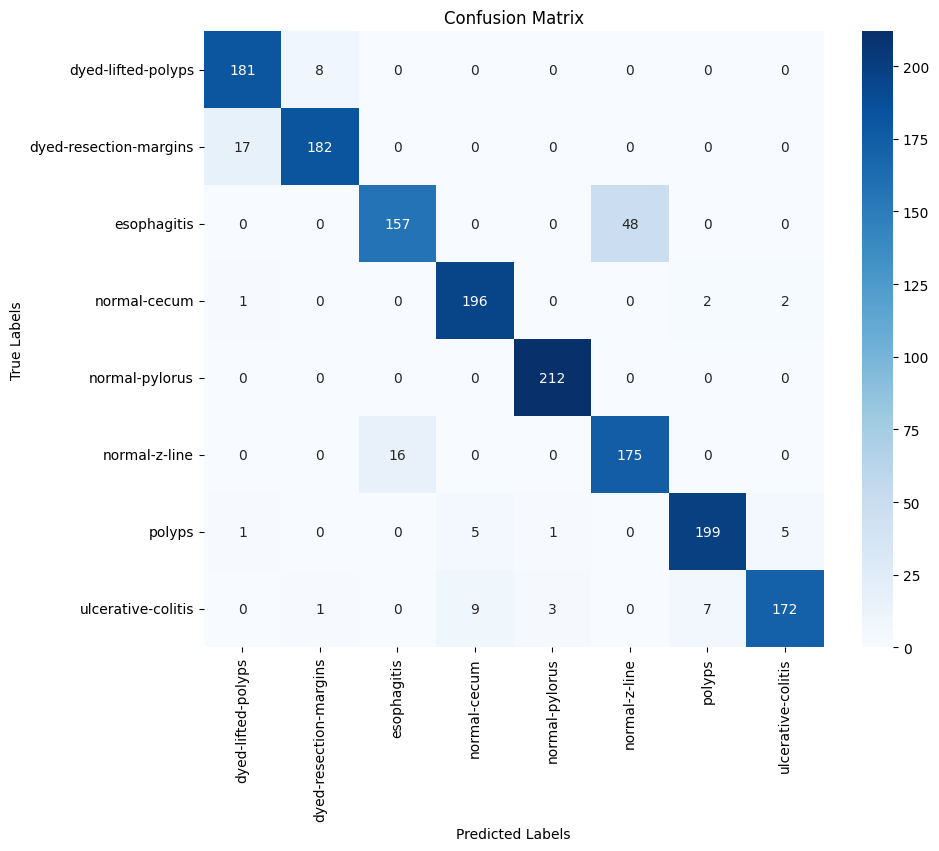

In [147]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have ground truth labels (val_targets) and model predictions (val_predictions)
y_true = val_targets  # Ground truth labels
y_pred = np.argmax(val_predictions, axis=1)  # Predicted labels (assuming you have softmax output)

# Generate a classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)  # Provide class names if available
print("Classification Report:\n", class_report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Title: Kvasir GI Image Classification

Introduction:
This code performs an analysis of the Kvasir Gastrointestinal (GI) dataset and trains a machine learning model(MobileOne) for image classification. The dataset consists of various GI-related images, and the goal is to classify them into different classes based on their content.

Code Structure:

1. Importing Libraries:

The necessary libraries for data handling, visualization, model creation, and training are imported.

2. Data Loading and Preprocessing:

The Kvasir GI dataset is downloaded and extracted.
Custom data transformations are defined for the training and validation datasets.
The dataset is split into training and validation sets.
Data loaders are created for batch processing.

3. Exploratory Data Analysis (EDA):

Basic dataset information is displayed, including the number of classes, class labels, and the total number of samples.
Class distribution is visualized through bar plots, showing the count and percentage of each class.
Class distribution for both the training and validation sets is compared through bar charts.

4. Data Visualization:

A function is defined to display sample images from the dataset for visual inspection.

5. Model Creation:

A custom neural network model (MobileNetOne) is defined. It loads a pre-trained MobileNetV2 model and modifies its classifier for the specific classification task.
Loss function (CrossEntropyLoss) and optimizer (Adam) are defined.
The model is moved to the GPU if available.

6. Callbacks for Training:

Custom callback classes are defined for early stopping and model checkpoint uploads to Google Cloud Storage.
Callbacks are used to monitor and control the training process.

7. Training the Model:

The model is trained using Poutyne's fit_generator method.
Training and validation data loaders, loss function, and optimizer are passed to the model.
Callbacks for early stopping and model checkpoint uploads are employed during training.

8. Custom Metrics and Evaluation:

Custom callback classes are used to calculate and log custom metrics like accuracy, top-3 accuracy, top-5 accuracy, and F1-score.
Classification report and confusion matrix are generated to evaluate the model's performance.

Conclusion:
This code provides a comprehensive workflow for analyzing and training a deep learning model on the Kvasir GI dataset. It includes data preprocessing, exploratory data analysis, model creation, training with custom callbacks, and evaluation of classification performance.

In [146]:
import time

while True:
    print("Colab is still running...")
    time.sleep(180)

Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is still running...
Colab is sti

KeyboardInterrupt: ignored